# Creating VIIRS composites from the LEN repository

In [15]:
import sys, os, datetime
import geojson, imageio, rasterio

import sys, os, inspect, logging, json
import rasterio, boto3

import numpy as np
import xarray as xr
import rioxarray as rxr
import pandas as pd
import geopandas as gpd
import GOSTRocks.rasterMisc as rMisc

from GOSTRocks.misc import tPrint
from shapely.geometry import shape, Point

sys.path.append("../src")

import len_tools 
from len_tools import Catalog
from len_tools import VIIRS_cleaner

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
aws_bucket = 'globalnightlight'
iso3 = 'UKR'
out_folder = "/home/wb411133/temp/UKR/"
if not os.path.exists(out_folder):
    os.makedirs(out_folder)
    
shift_folder = os.path.join(out_folder, "SHIFTED")
if not os.path.exists(shift_folder):
    os.makedirs(shift_folder)

adm0 = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
adm0 = adm0.loc[adm0.iso_a3 == iso3]

adm1 = gpd.read_file('/home/wb411133/data/Projects/UKR_Damage/Data/Admin/OCHA/ukr_admbnda_adm1_sspe_20220114.shp')

In [5]:
cat = Catalog()

In [6]:
start_day = "2022-01-01"
end_day = "2022-05-12"
# Generate catalog of images for country and time period
current_cat = cat.search_by_period(start_day, end_day)
current_cat = current_cat.search_by_intersect(adm0, calc_overlap=True)
current_cat.scenes = current_cat.scenes.sort_values(['datetime'])

/home/wb411133/.conda/envs/ee/lib/python3.9/site-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


In [7]:
# Throw away scenes with coverage lower than 25%
sel_scenes = current_cat.scenes.loc[current_cat.scenes.overlap > 0.25]

In [ ]:
cleaner = VIIRS_cleaner(aws_bucket, sel_scenes, adm0.unary_union.buffer(2))
res = cleaner.clean_viirs_data(attach_numpy=True)

In [ ]:
cleaner.write_output(out_folder, f'{iso3}_{start_day}_{end_day}')

In [ ]:

cleaner.write_output_shift(res['scenes'], shift_folder)

In [ ]:
scenes = cleaner.scenes.sort_values(['datetime'])
scenes['datetime'] = pd.to_datetime(scenes['date'])
min_date = scenes['datetime'].min()
max_date = scenes['datetime'].max()

cur_date = min_date

while cur_date < max_date:
    print(cur_date)
    cur_date = cur_date + pd.DateOffset(days=7)


# Calculate VIIRS quality

In [ ]:
# calculate the quality of the VIIRS data (vflag)
quality_res = {}
for idx, row in scenes.iterrows():
    cur_quality = res['scenes'][idx][1]    
    total_pixels = cur_quality.shape[0] * cur_quality.shape[0]
    good_pixels = cur_quality.sum()
    quality_res[datetime.datetime.strftime(row['date'], "%Y-%m-%d")] = (good_pixels/total_pixels)
quality_res

In [ ]:
pd.DataFrame(quality_res, index=[0]).transpose().plot(
    figsize=(15,7), colormap='magma', legend=False, rot=45,
    ylabel = "Fraction of pixels that are good"


)

# Map VIIRS 

In [ ]:
# Generate animation of change in nighttime lights
def map_viirs(cur_file, out_file='', class_bins = [-10,0.5,1,2,3,5,10,15,20,30,40,50], text_x=0, text_y=5, dpi=300):
    ''' create map of viirs data
    
    INPUT
        cur_file [string] - path to input geotif
        [optional] out_file [string] - path to create output image
        [optional] class_bins [list numbers] - breaks for applying colour ramp
        [optional] text_x [int] - position on map to position year text (left to right)
        [optional] text_y [int] - position on map to position year text (top to bottom)
    '''
    # extract the year from the file name
    year = cur_file.split("_")[2]
    
    # Open the VIIRS data and reclassify 
    inR = rasterio.open(cur_file)
    inD = inR.read() 
    inD[np.isnan(inD)] = 0
    inC = xr.apply_ufunc(np.digitize,inD,class_bins)

    # Plot the figure, remove grid and ticks
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])
    
    ### TODO: add the year to the map, may need to experiment with the location depend on geography
    # ax.text(text_x, text_y, year, fontsize=40, color='white')

    #plt.margins(0,0)
    if out_file != '':
        #plt.imsave(out_file, inC[0,:,:], cmap=plt.get_cmap('magma'))
        plt.imshow(inC[0,:,:], cmap=plt.get_cmap('magma'))
        fig.savefig(out_file, dpi=dpi, bbox_inches='tight', pad_inches=0)
    else:
        # https://matplotlib.org/stable/tutorials/colors/colormaps.html
        plt.imshow(inC[0,:,:], cmap=plt.get_cmap('magma'))
    
maps_folder = os.path.join(out_folder, "SHIFTED_MAPS")

for in_file in os.listdir(shift_folder):
    if in_file.endswith("_rad.tif"):
        xx = map_viirs(os.path.join(shift_folder, in_file), os.path.join(maps_folder, in_file))        
        tPrint(in_file)
        

In [ ]:
kwargs = {'duration':0.4}
images = []
all_tifs = [os.path.join(maps_folder, x) for x in os.listdir(maps_folder) if x.endswith(".tif")]
all_tifs.sort()

images.append(imageio.imread(all_tifs[0]))
images.append(imageio.imread(all_tifs[0]))
for filename in all_tifs:
    images.append(imageio.imread(filename))
#append the final image 3 times
images.append(imageio.imread(all_tifs[-1]))
images.append(imageio.imread(all_tifs[-1]))
images.append(imageio.imread(all_tifs[-1]))


imageio.mimsave(os.path.join(maps_folder, f'ANIMATION_{start_day}_{end_day}.gif'), images, **kwargs)

# Generate difference images

In [76]:
all_tifs = [os.path.join(shift_folder, x) for x in os.listdir(shift_folder) if x.endswith("rad.tif")]
all_tifs

['/home/wb411133/temp/UKR/SHIFTED/SHIFTED_20220101_20220129_rad.tif',
 '/home/wb411133/temp/UKR/SHIFTED/SHIFTED_20220108_20220205_rad.tif',
 '/home/wb411133/temp/UKR/SHIFTED/SHIFTED_20220115_20220212_rad.tif',
 '/home/wb411133/temp/UKR/SHIFTED/SHIFTED_20220122_20220219_rad.tif',
 '/home/wb411133/temp/UKR/SHIFTED/SHIFTED_20220129_20220226_rad.tif',
 '/home/wb411133/temp/UKR/SHIFTED/SHIFTED_20220205_20220305_rad.tif',
 '/home/wb411133/temp/UKR/SHIFTED/SHIFTED_20220212_20220312_rad.tif']

In [77]:
inR0 = rasterio.open(all_tifs[0])
inR1 = rasterio.open(all_tifs[-1])

inR0_data = inR0.read()
inR1_data = inR1.read()

diff_data = inR1_data - inR0_data
per_change = diff_data/inR0_data

out_file = os.path.join(out_folder, "VIIRS_change.tif")
out_file_per = os.path.join(out_folder, "VIIRS_change_per.tif")

with rasterio.open(out_file, 'w', **inR0.meta) as out_raster:
    out_raster.write(diff_data)
    
with rasterio.open(out_file_per, 'w', **inR0.meta) as out_raster:
    out_raster.write(per_change)

# Summarize NTL in ADM1

In [27]:
ntl_res = adm1.loc[:,['ADM1_EN','ADM1_PCODE']]

for cur_tif in all_tifs:
    res = rMisc.zonalStats(adm1, cur_tif, minVal=1)
    tif_date = cur_tif.split("_")[-3]
    res = pd.DataFrame(res, columns = ['SUM', 'MIN', 'MAX', 'MEAN'])
    ntl_res[f'NTL_{tif_date}'] = res['SUM']
    tPrint(cur_tif)

09:19:03	/home/wb411133/temp/UKR/SHIFTED/SHIFTED_20220101_20220129_rad.tif
09:19:04	/home/wb411133/temp/UKR/SHIFTED/SHIFTED_20220108_20220205_rad.tif
09:19:05	/home/wb411133/temp/UKR/SHIFTED/SHIFTED_20220115_20220212_rad.tif
09:19:05	/home/wb411133/temp/UKR/SHIFTED/SHIFTED_20220122_20220219_rad.tif
09:19:06	/home/wb411133/temp/UKR/SHIFTED/SHIFTED_20220129_20220226_rad.tif
09:19:07	/home/wb411133/temp/UKR/SHIFTED/SHIFTED_20220205_20220305_rad.tif
09:19:08	/home/wb411133/temp/UKR/SHIFTED/SHIFTED_20220212_20220312_rad.tif


In [ ]:
ntl_res = ntl_res.sort_values('NTL_20220101', ascending=False)
ntl_plot = ntl_res.drop(['ADM1_PCODE', 'ADM1_EN'], axis=1).transpose()
ntl_plot.columns = adm1['ADM1_EN']
def map_ntl(map_data):
    pd.DataFrame(map_data).plot(
        figsize=(20,10), colormap='copper', legend=True, rot=45, 
        ylabel=' Sum of Lights'
    )

map_ntl(ntl_plot.iloc[:,0:9])

In [ ]:
map_ntl(ntl_plot.iloc[:,8:18])

In [ ]:
map_ntl(ntl_plot.iloc[:,17:])

# Summarize population in VIIRS images

In [10]:
pop_layer = "/home/wb411133/data/Projects/UKR_Damage/Data/ukr_ppp_2020_UNadj_constrained.tif"
pop_s = pop_layer.replace(".tif", "_standardized.tif")
inPop = rasterio.open(pop_layer)

In [113]:
all_tifs = [os.path.join(shift_folder, x) for x in os.listdir(shift_folder) if x.endswith("rad.tif")]

inR0 = rasterio.open(all_tifs[0])
popD, pop_meta = rMisc.standardizeInputRasters(inPop, inR0)
popD[popD<0] = 0
class_bins = [-10,0.5,1,2,3,5,10,15,20,30,40,50]

In [114]:
cur_res = {}

for ntl_file in all_tifs:
    cur_date = ntl_file.split("_")[-3]
    inR = rasterio.open(ntl_file)
    ntlD = inR.read()    
    ntlC = xr.apply_ufunc(np.digitize, ntlD, class_bins)
    class_res = []
    for cur_class in np.unique(ntlC):
        cur_ntl = ntlC == cur_class
        cur_pop = popD * cur_ntl
        class_res.append(cur_pop.sum())
    cur_res[cur_date] = class_res
    tPrint(os.path.basename(ntl_file))

16:06:59	SHIFTED_20220101_20220129_rad.tif
16:07:01	SHIFTED_20220108_20220205_rad.tif
16:07:02	SHIFTED_20220115_20220212_rad.tif
16:07:03	SHIFTED_20220122_20220219_rad.tif
16:07:05	SHIFTED_20220129_20220226_rad.tif
16:07:06	SHIFTED_20220205_20220305_rad.tif
16:07:08	SHIFTED_20220212_20220312_rad.tif


In [115]:
ntl_res = pd.DataFrame(pd.DataFrame(cur_res).transpose())
ntl_res = ntl_res.drop(['20220101'])
ntl_res.columns = [f'NTL {x}' for x in ['< 0',0,1,2,3,5,10,15,20,30,40,50]]
ntl_res.head()

,NTL < 0,NTL 0,NTL 1,NTL 2,NTL 3,NTL 5,NTL 10,NTL 15,NTL 20,NTL 30,NTL 40,NTL 50
20220108,2127852.0,2894147.50,5732622.0,4291361.0,6057928.5,9106668.0,4966217.5,3074046.00,3396489.500,1.926047e+06,1.032988e+06,10493926.0
20220115,2283977.0,3177652.25,5727116.5,4731560.0,6497697.0,9421074.0,5043765.0,3089975.50,3257165.000,1.953254e+06,8.910259e+05,9026049.0
20220122,2283977.0,3177652.25,5727116.5,4731560.0,6497697.0,9421074.0,5043765.0,3089975.50,3257165.000,1.953254e+06,8.910259e+05,9026049.0
20220129,2595271.0,4571153.00,7136595.5,5478991.5,7063116.0,8763159.0,4395427.0,2690661.50,2811446.500,1.338929e+06,7.036369e+05,7551903.0
20220205,6004106.5,10237463.00,9448226.0,5299602.5,5994895.0,6255842.5,2573672.0,1255848.75,1223596.875,5.070542e+05,1.652540e+05,6134720.0


<AxesSubplot:>

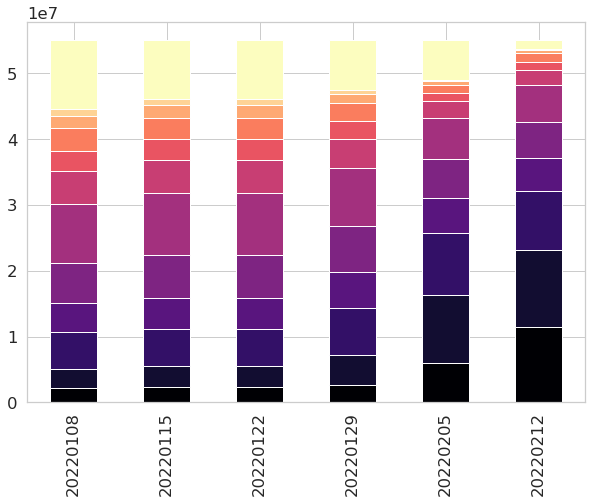

In [116]:
ntl_res.plot(kind='bar', stacked=True, figsize=(10,7), colormap='magma', legend=False)

In [117]:
# Summarize population in nighttime list change
ntl_change_per = os.path.join(out_folder, "VIIRS_change_per.tif")
inR_ntlp = rasterio.open(ntl_change_per)
percent_change = inR_ntlp.read()

In [118]:
# Summarize change in nighttime lights by threshold om oblasts
ntl_res = adm1.copy()
ntl_res.drop(['geometry'], axis=1, inplace=True)
#Calculate total population
with rMisc.create_rasterio_inmemory(pop_meta, popD) as popR:
    pop_res = rMisc.zonalStats(adm1, popR, minVal=0)
    pop_res = pd.DataFrame(pop_res, columns=['SUM','MIN','MAX','MEAN'])
    ntl_res['TotalPop'] = pop_res['SUM']

for thresh in [-0.1, -0.25, -0.5, -0.9]:    
    perD =  percent_change > thresh
    decreasePop = popD * perD.astype(int)
    with rMisc.create_rasterio_inmemory(changeR.profile, decreasePop) as decreasePopNTLR:
        cur_res = rMisc.zonalStats(adm1, decreasePopNTLR)
        cur_res = pd.DataFrame(cur_res, columns=['SUM','MIN','MAX','MEAN'])
        ntl_res[f'PopD_{int(abs(thresh)*100)}'] = cur_res['SUM']
        tPrint(thresh)

16:07:09	-0.1
16:07:10	-0.25
16:07:11	-0.5
16:07:11	-0.9


In [119]:
pd.DataFrame(ntl_res.sort_values('ADM1_EN')).to_csv(os.path.join(out_folder, "NTL_change_results.csv"))

In [64]:
# What percent of the population has seen lights decrease
decreaseD = changeD < 0
decreasePop = decreaseD * popD
print(f'{round(decreasePop.sum())} people have seen light decrease, which is {round(decreasePop.sum()/popD.sum() * 100)}%')

46017992 people have seen light decrease, which is 84%


In [25]:
# What percent of the population has seen lights decrease by at least 50%
thresh = -0.50
percent_change = changeD/ntlT1D
perD =  percent_change < thresh
decreasePop = decreaseD * perD
print(f'{round(decreasePop.sum())} people have seen light decrease by {thresh}, which is {round(decreasePop.sum()/popD.sum() * 100)}%')

4180686 people have seen light decrease by -0.5, which is 8%


In [ ]:
popD.sum()

# Debugging